<a href="https://colab.research.google.com/github/byunsy/bcr-rep-analysis/blob/main/BCR_Repertoire_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup Requirements

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as figure
import seaborn as sns
import warnings
import os
import csv
from sklearn.manifold import TSNE

### Vector-Reference Data

This is a pre-trained 3-gram dataset that we can use as a reference or a lookup table.

**Note:** This data was acquired from: https://dataverse.harvard.edu/file.xhtml?fileId=2712445&version=RELEASED&version=.1 

**Reference:** Asgari, Ehsaneddin and Mofrad Mohmmad R.K. "Continuous Distributed Representation of Biological Sequences for Deep Proteomics and Genomics". PloS one (2015). In Press.

In [ ]:
# Download the csv file and upload it. Then run this code.
vec_ref = pd.read_csv("/content/protVec_100d_3grams.csv", sep="\t", index_col ="words")

In [ ]:
# Change the columns to simple integers [1,100], which represents 100-dimensions
vec_ref.columns = range(1,101)
vec_ref

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
words,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAA,-0.174060,-0.095756,0.059515,0.039673,-0.375934,-0.115415,0.090725,0.173422,0.292520,0.190375,0.094091,-0.197482,-0.135202,0.075521,0.110771,0.047909,-0.391934,0.073548,0.103868,-0.045924,-0.009534,0.055659,-0.000308,0.215941,0.084476,0.061573,0.128139,0.184247,-0.100091,-0.126661,-0.005728,-0.038272,0.180597,-0.155310,0.056232,-0.005925,-0.085381,-0.056921,-0.045520,0.265116,...,0.078108,0.203824,-0.100126,0.294703,-0.158841,0.029333,0.078265,0.018524,0.117082,0.212755,-0.171555,0.029421,0.149264,0.046599,-0.184111,0.294123,-0.101497,-0.030123,-0.009826,0.007835,-0.106508,-0.166202,-0.024748,-0.090856,0.056977,0.047644,0.018618,-0.034376,0.087013,-0.278817,0.244482,0.015974,0.012903,0.137528,0.138140,0.005474,0.070719,-0.164084,-0.179274,0.184899
ALA,-0.114085,-0.093288,0.155800,-0.037351,-0.121446,0.084037,0.023819,0.093442,0.143256,0.044627,-0.105535,-0.087031,-0.147241,0.012367,0.002243,-0.041897,-0.182035,0.080363,0.135968,0.032804,-0.032578,-0.081669,-0.053846,0.067459,-0.011088,-0.126765,0.107745,0.006742,-0.044855,-0.077349,0.054623,-0.059747,-0.091474,-0.132825,0.066172,-0.045547,-0.092852,-0.020580,-0.016422,0.082413,...,0.014453,0.145755,-0.008099,0.176967,-0.062075,0.084897,0.082622,0.053887,-0.013649,0.024531,-0.118647,0.020675,0.073420,-0.042731,-0.010526,0.056253,-0.057254,0.002313,0.061039,0.063857,0.097188,-0.012246,-0.004977,0.088645,0.098434,-0.144351,-0.096486,0.096045,-0.052779,-0.021758,0.075584,-0.139661,0.034863,0.056078,0.028975,-0.012233,0.059669,0.037811,-0.172493,0.074655
LLL,-0.075594,-0.100834,-0.046616,-0.208980,-0.008596,-0.038612,-0.049360,0.060720,-0.062662,-0.155879,-0.095449,0.052816,-0.022683,0.174553,-0.072320,0.143376,0.053296,0.055474,0.121997,0.141793,-0.004449,0.040127,-0.035727,0.072882,-0.133617,-0.120842,-0.032419,-0.071970,-0.031463,-0.138865,-0.032375,-0.097968,-0.183033,-0.036964,0.059410,-0.002993,-0.201955,-0.030150,0.051579,-0.114557,...,0.036492,0.142790,0.014206,0.092198,0.151291,0.166428,0.080345,-0.082877,0.115355,-0.004289,-0.065504,0.098610,-0.004312,-0.146300,0.011714,-0.008307,-0.133138,0.004990,0.019846,0.025801,-0.121587,-0.055280,0.134006,0.142266,-0.040343,0.032380,-0.006457,0.024851,0.097393,-0.123801,0.174677,-0.175961,-0.193242,-0.072965,-0.075560,0.158286,-0.026378,0.037155,-0.176038,0.319293
LAA,-0.137546,-0.135425,0.121566,-0.038295,-0.212129,0.040009,0.078545,0.029837,0.138343,0.049377,0.025048,-0.050824,0.058681,0.086782,-0.073994,-0.024942,-0.099726,0.024913,0.048674,0.006191,0.015447,-0.029424,0.083410,0.012713,-0.026227,-0.123598,0.021424,0.068988,-0.058738,-0.049295,-0.023567,-0.083769,-0.049185,-0.127975,0.151709,-0.108231,-0.049147,-0.039074,0.019889,0.103406,...,-0.018289,0.211769,-0.116390,0.196089,-0.099020,0.030546,0.064562,0.081074,-0.010765,0.026536,-0.080675,0.017583,0.115859,-0.032546,-0.080149,0.099125,-0.017189,0.009218,0.095391,0.011473,0.043502,-0.013087,0.085062,0.088393,0.064209,0.017879,-0.066337,0.114686,-0.032628,-0.103722,0.133947,-0.156484,-0.048541,0.141848,0.081842,0.070573,0.006927,0.035281,-0.138971,0.105997
AAL,-0.156112,-0.133524,0.114426,-0.020264,-0.058513,0.057005,0.076881,0.054781,0.129436,0.019448,0.043217,-0.040845,-0.096708,0.098465,0.093350,-0.006103,-0.141243,0.010853,0.036400,0.037815,-0.051536,-0.015011,0.033248,0.038065,0.066691,-0.143604,0.030678,0.082085,-0.080047,-0.122871,0.046394,-0.148947,-0.046421,-0.036942,0.036437,-0.018360,-0.130727,-0.021232,0.013852,0.038774,...,0.115308,0.133448,-0.137941,0.240588,-0.078791,0.055487,0.105860,0.094220,0.003375,-0.010997,-0.188596,0.017699,0.097138,-0.060761,-0.077964,0.088613,-0.004523,-0.025586,0.055520,0.049160,0.002751,-0.029583,0.025475,0.07064

### SplitSequence and CreateProtVec Functions

In [ ]:
"""============================================================================
PROCEDURE:
    SplitSequence
PARAMETERS:
    aa_str, an amino acid sequence
PURPOSE:
    Creates three different lists of shifted non-overlapping 3-grams
PRODUCES:
    ret, a list of three lists (non-overlapping 3-grams)
============================================================================"""
def SplitSequence(aa_str):
    # Three separate lists to store 3-grams
    ret = [[],[],[]]

    # Create sliding window of 3-grams
    for i in range(len(aa_str)):
        seq = aa_str[i:i+3]
        
        if len(seq) == 3:
            # Append based on its index position
            if i%3 == 0:
                ret[0].append(seq)
            elif i%3 == 1:
                ret[1].append(seq)
            elif i%3 == 2:
                ret[2].append(seq)
    return ret

In [ ]:
"""============================================================================
PROCEDURE:
    CreateProtVec
PARAMETERS:
    aa_str, an amino acid sequence
PURPOSE:
    Creates a 'ProtVec' for a protein sequence of interest
PRODUCES:
    protvec, the sum of three 100-dimension vectors, represented as a single
    100-dimensional vector (returned as a pd.Series)   
============================================================================"""
def CreateProtVec(aa_str):

    # A list to store three 100-dimensional vectors
    protvec = []

    # For each of the three non-overlapping 3-grams lists
    for splits in SplitSequence(aa_str):

        # Create dictionary and index counter to store vectors
        data = {}

        # For each 3-gram, look up in vec_ref and store the 100d vector
        for i, seq in enumerate(splits):

            try:
                # Bring the 100-dimensional vector from vec_ref
                data[i] = vec_ref.loc[seq]
            except:
                # Some sequences are not found (eg. if it includes 'X')
                # print(f"{seq} not found.")
                data[i] = vec_ref.loc['<unk>']

        # Create dataframe directly from the dictioanry (data)
        vec_d100 = pd.DataFrame.from_dict(data, "index")
            
        # Summation of each column (dimension) in vec_d100
        # - this will produce a single 100-dimension vector for each split
        # Append the summed vector to protvec (list)
        # - this will produce a list of three 100d vectors
        if not vec_d100.empty:
            protvec.append(vec_d100.sum(axis=0))

    if protvec:
        # Finally return the sum of the three vectors (a single 100d vector)
        return sum(protvec)

    else:
        return pd.Series([], dtype='float64')

### Connect to Elastic Search

In [ ]:
# Install Elasticsearch
!pip3 install elasticsearch

     |████████████████████████████████| 363 kB 26.9 MB/s 


In [ ]:
# Connect to Elasticsearch Server
from elasticsearch import Elasticsearch
es = Elasticsearch(hosts=["###.##.###.###", "###.##.###.###"], http_auth=('###', '###'), timeout=500)

### GetBCR_CDR3 Functions

We have two functions: `GetBCR_CDR3()` and `GetBCR_CDR3_json()`.

This is because our elasticsearch database has two types of datasets (CSV format and JSON format), and thus have different index names. We will simply create two separate functions to deal with this issue. Both of these functions work exactly the same, except that they may differ in some of key/index terms (eg. cdr3_aa vs cdr3, redundancy vs Redundancy)

In [ ]:
"""============================================================================
PROCEDURE:
    GetBCR_CDR3
PARAMETERS:
    entity, an entity (patient or non-patient)
PURPOSE:
    Parses the entity data retrieved from elasticsearch (given an entity_id) 
    and finds the top 100 most redundant CDR3 amino acid sequences. 
PRODUCES:
    cdr_seq, a list of 100 most redundant CDR3 amino acid sequence of 
    a given entity, sorted in descending order.
============================================================================"""
def GetBCR_CDR3(entity_id):
    
    # 1. Retrieve the BCR CDR3 amino acid sequences............................
    
    # Get '_source' data (which includes cdr3_aa sequences) from given entity
    cdr_seq = [seq['_source'] for seq in es.search(
                    index = 'oas_sequence', 
                    sort = ["Redundancy:desc"], 
                    size = 500000, # Max size
                    body = {
                        "query": {
                            "match_phrase": {
                                "entity_id.keyword": entity_id
                            }
                        }
                    }
                )['hits']['hits']]

    # 2. Find the top 100 most redundant CDR3 sequences........................
    
    # Create dict to store CDR3 redundancy values 
    redund_dict = {}

    # For each sequence data from an entity we found from above
    for seq_data in cdr_seq:

        # If CDR3 sequence is not already in redund_dict, add new key/value
        if seq_data['cdr3_aa'] not in redund_dict:
            redund_dict[seq_data['cdr3_aa']] = seq_data['Redundancy']

        # If already in redund_dict, increase its redundancy value
        else:
            redund_dict[seq_data['cdr3_aa']] += seq_data['Redundancy']

    # Sort redund_dict by its values (total redundancy value)
    sorted_dict = {k: v for k, v in sorted(redund_dict.items(), 
                                           key=lambda item: item[1], 
                                           reverse=True)}

    # Return the top 100 most redundant CDR3 sequences
    return list(sorted_dict.keys())[:100]

In [ ]:
"""============================================================================
PROCEDURE:
    GetBCR_CDR3_json
PARAMETERS:
    entity, an entity (patient or non-patient)
PURPOSE:
    Parses the entity data retrieved from elasticsearch (given an entity_id) 
    and finds the top 100 most redundant CDR3 amino acid sequences. 
PRODUCES:
    cdr_seq, a list of 100 most redundant CDR3 amino acid sequence of 
    a given entity, sorted in descending order.
============================================================================"""
def GetBCR_CDR3_json(entity_id):
    
    # .........................................................................
    # 1. Retrieve CDR3 amino acid sequences from oas_sequence_json

    # Get '_source' data (which includes cdr3_aa sequences) from given entity
    cdr_seq = [seq['_source'] for seq in es.search(
                    index = 'oas_sequence_json', 
                    sort = ["redundancy:desc"], 
                    size = 500000, # Max size
                    body = {
                        "query": {
                            "match_phrase": {
                                "entity_id.keyword": entity_id
                            }
                        }
                    }
                )['hits']['hits']]

    # .........................................................................
    # 2. Find the top 100 most redundant CDR3 sequences
    
    # Create dict to store redundancy values 
    redund_dict = {}

    # For each sequence data from an entity we found from above
    for seq_data in cdr_seq:

        # If CDR3 sequence is not already in redund_dict, add new key/value
        if seq_data['cdr3'] not in redund_dict:
            redund_dict[seq_data['cdr3']] = seq_data['redundancy']

        # If already in redund_dict, increase its redundancy value
        else:
            redund_dict[seq_data['cdr3']] += seq_data['redundancy']

    # Sort redund_dict by its values (total redundancy value)
    sorted_dict = {k: v for k, v in sorted(redund_dict.items(), 
                                           key=lambda item: item[1], 
                                           reverse=True)}

    # Return the top 100 most redundant CDR3 sequences
    return list(sorted_dict.keys())[:100]

In [ ]:
# ==============================================================================
# Check if it works properly
# ==============================================================================
# Acquire the first 10 entities
res = es.search(index = 'oas_entity', size = 10)

# Select the first entity
ent = res['hits']['hits'][0]

# Run GetBCR_CDR3 function for that given entity
redun_cdr3 = GetBCR_CDR3(ent['_id'])
print(redun_cdr3)
print(len(redun_cdr3))

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


['AKDSGNDYGDQLDY', 'TRVPPYSNSWWDAFDI', 'AKGESNNWSFFDY', 'ASLSTGYVWDKFDY', 'AGGQDVDSGRYGGMDV', 'ARVRGSYALDY', 'AKGPIAVVPGGKMWLDP', 'ARDDYAAADASWDLRNDGFDV', 'ARARGGSYYYGMDV', 'ANPRVLY', 'ARSIAGSYYYGMDV', 'ARDEWLRERRTDY', 'ARGWSATGIDP', 'ARDPLGDGYSFSDY', 'ARPMVRSHQVVFGSYDT', 'ARKERMNGETAPNWYFDL', 'AKVDAVDGDMAGMDV', 'AKDLGSDYGDQLGY', 'ARDPVGDGYSFFDY', 'AKGPIAVVSGGKMWLDP', 'ARLVSENSAVEY', 'ARGPPIGGGDCYSH', 'AAGAPGH', 'VKDREYTSSLDRRYFDL', 'ARGFDY', 'VRGAVTGDYGMDV', 'ARGGWKRGWKDLEYDSSGYYFGAFDI', 'AKSTFDIVVVPAAPDLDY', 'AHRQVLVGGNSGFYY', 'ARGGYSLRLYYYYGMDV', 'ASSLAVTGTRHFDF', 'ARGPSGWRFDP', 'AKAPIALVPAGKMWFDP', 'ARGAPGH', 'AKDSGNDFGDQLDY', 'TRVPSYSSSWWDAFDI', 'ARVMEYCTVTSCAMFDF', 'ARDLGDYGMDV', 'AKGTTITVYSATNY', 'VKDLSGLAKVN', 'ARGPSAWRFDP', 'ARDPVADGYSFFDY', 'ARGYISGPFDS', 'AREVQHSNSFDY', 'VKGESNNWSFFDY', 'ARAGLGYYDSSGYWNDAFDI', 'ARDPEDNSYGSFFDY', 'AKDLSGLAKVN', 'ARGVPGY', 'ARVPPAGAGHSGYDRFDY', 'ARDFRFGEDDAFDI', 'AKEVSYYSGSGSDY', 'ARGDYNSDWHYFDY', 'AKGGMTTPIDHDY', 'ARLGMGWELLAPEYYFDY', 'ARGNYY

### RetrieveEntities Function


In [ ]:
def RetrieveEntities(disease, isotype, num_entities):

    entities = [seq for seq in es.search(
                index = 'oas_entity', 
                size = num_entities, # Max size
                body = {
                    "query": {
                        "bool": {
                            "filter": [
                                {
                                    "match_phrase": {
                                        "Disease.keyword": disease
                                    }
                                },
                                {
                                    "match_phrase": {
                                        "Isotype.keyword": isotype
                                    }
                                }    
                            ]
                        }
                    }
                }
    )['hits']['hits']]

    entities_json = [seq for seq in es.search(
                index = 'oas_entity_json', 
                size = num_entities, # Max size
                body = {
                    "query": {
                        "bool": {
                            "filter": [
                                {
                                    "match_phrase": {
                                        "Disease.keyword": disease
                                    }
                                },
                                {
                                    "match_phrase": {
                                        "Isotype.keyword": isotype
                                    }
                                }    
                            ]
                        }
                    }
                }
    )['hits']['hits']]

    return entities, entities_json

### Acquire Data from Elasticsearch Database
- We need BCR CDR3 amino acid sequences for SARS-COV-2 patients and non-patients.
- Possibly other diseases in the future (eg. HIV, Allergies, Dengue)

In [ ]:
"""============================================================================
Chain     : Heavy
Isotype   : IGHG or IGHA
Disease   : SARS-COV-2 (Patient) vs None (Normal)
Redundancy: Top 100 (the most redundant 100 sequences)
Vaccines  : None
============================================================================"""
# Set the number of entities to acquire from db
# We have a total of 2,187 samples (entities or individuals)
# This is when we have no filter whatsoever.

# oas_entity      : 1464 (804 healthy + 660 patient = 1464)
# oas_entity_json : 723  (723 healthy + 0 patient = 723)
# Total           : 1464 + 723 = 2187

# Normal + Patient = 1527 + 660 = 1786

# **Note: when we apply the filters (chains, isotype, etc.) described above**
# -  Number of Patients: 106 (106 oas_entity + 0 oas_entity_json)
# -  Number of Normal  : 349 (165 oas_entity + 184 oas_entity_json)
# ..............................................................................

# Set max number of entities to call from elasticsearch
NUM_ENTITY = 2200

# Change the variable depending on IGHG vs IGHA
ISOTYPE = 'IGHG'

# Create counters for both patients and non-patients
patient_cnt = 0
normal_cnt = 0

# Create dicts to store all the 100 CDR3 sequences from each individual
cdr_indv_patient = {}
cdr_indv_normal = {}

# Store author and subject information 
cdr_indv_patient_subj = []
cdr_indv_normal_subj = []

# Acquire entity information from elasticsearch
patient_ent, patient_ent_j = RetrieveEntities("SARS-COV-2", ISOTYPE, NUM_ENTITY)
normal_ent, normal_ent_j  = RetrieveEntities("None", ISOTYPE, NUM_ENTITY)

# For 'SARS-COV-2' oas_entities(i=0) and oas_entities_json(i=1)
for i, ent in enumerate([patient_ent, patient_ent_j]):

        for entity in ent:

            # Get a full list of most redundant CDR3 sequences
            if not i:
                cdr3 = GetBCR_CDR3(entity['_id'])
            else:
                cdr3 = GetBCR_CDR3_json(entity['_id'])

            # Only take ones with 100 sequences
            if len(cdr3) == 100:

                # Store CDR3 sequences in cdr_indv_hiv in dict format
                cdr_indv_patient[patient_cnt] = cdr3

                # Increment hiv_cnt
                patient_cnt += 1

                # Append subject and time point information
                seq_subject = entity['_source']['Subject']
                seq_timepoint = entity['_source']['Longitudinal']
                cdr_indv_patient_subj.append(f"{seq_subject}_{seq_timepoint}")

# For 'None' oas_entities(i=0) and oas_entities_json(i=1)
for i, ent in enumerate([normal_ent, normal_ent_j]):

        for entity in ent:

            # Get a full list of most redundant CDR3 sequences
            if not i:
                cdr3 = GetBCR_CDR3(entity['_id'])
            else:
                cdr3 = GetBCR_CDR3_json(entity['_id'])

            # Only take ones with 100 sequences
            if len(cdr3) == 100:

                # Store CDR3 sequences in cdr_indv_patient in dict format
                cdr_indv_normal[normal_cnt] = cdr3

                # Increment normal_cnt
                normal_cnt += 1

                # Append subject and time point information
                seq_subject = entity['_source']['Subject']
                seq_timepoint = entity['_source']['Longitudinal']
                cdr_indv_normal_subj.append(f"{seq_subject}_{seq_timepoint}")


print("CDR3 Sequences .................................")
print("Number of Patients:",len(cdr_indv_patient))
print("Number of Normal:",len(cdr_indv_normal))
print()

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:208: ElasticsearchWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.13/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchWarning)


CDR3 Sequences .................................
Number of Patients: 106
Number of Normal: 322



In [ ]:
# ==============================================================================
# Check the results
# ==============================================================================
test1 = cdr_indv_patient[22]
print(test1)
print(len(test1))

['ARGHLSVSMIVVVFTSASYYFDY', 'ARHRNYGDHSLDNWFHP', 'ARAVSVRRAVNWFDP', 'ARENTVTTFGGPYYIDS', 'ARSVQFAYGLDV', 'ARSGVGIFDFSYFDS', 'ARRRLREDYFDF', 'AGDRGRFWHFDL', 'ARDVRYYYDQ', 'ARHWGIAAAGN', 'ARAPIYRSSWYAYFDY', 'AREVWFAEQPPGFDY', 'ARLLRSCSNGVCRTYYYYAMDV', 'ARDGYNAHQNYWYFDL', 'ARATSVRGAVSWFDP', 'ARGGATYYYDTSGYVNAFDT', 'AGRDGYKQTMDY', 'ARVARYCTNGVCQTYYYYGLDV', 'ARLGAITLVRGITKADFSNYGMDV', 'ARAYCGGDCNYLYIWFDS', 'ARGYYDILTGYLDAFDI', 'ARERITIFGVVTWPAYFDY', 'AASGRRGYSNPFHH', 'ARQDIQLRFDL', 'ARRPGASYYVFWSGGFDI', 'ARVHYYTGYVDS', 'AGDRGRFWQFDL', 'ARAVSVRRAVSWFDP', 'ARLLRSCTNGVCRTYYYYAMDV', 'ARRAGVVGDTRFDY', 'ARHMSDCSKGICHTYYYYGWDV', 'ARLLRSCTNGVCRTYYYYALDV', 'IQRVSVAGGPYYFDH', 'ARGLYNWNYEHWFDT', 'ARTSIAAAGTAIDY', 'ARHRDNLGSLNWFAP', 'ARRLDYWDSSGQRRHFDY', 'ARGGGSGYRYYFDY', 'ARHGGNDAFDI', 'ARVEFDGGYDSVPLDV', 'VRHPRTYNGFWSGYSGRLVFQFDS', 'ARDFVAAVPDRFDS', 'AKNRDIFWFGEGRDSMDV', 'AGHPFKSPWDPRPFDS', 'ARHSRGYLGPSYFDS', 'ARTRGYDPLFDF', 'ARGGYYDYAFDI', 'ASLEKLGYCSGDSCAGRPSL', 'ARGQRRTNRPNIVLGTASQRPFDY', 'ARHASYD

In [ ]:
# ==============================================================================
# Check the results
# ==============================================================================
print(len(cdr_indv_patient_subj))
print(len(cdr_indv_normal_subj))

106
322


### Convert all CDR3 sequences to ProtVecs in dataframe format

In [ ]:
"""============================================================================
PROCEDURE:
    CreateIndVecDF
PARAMETERS:
    seq_lst, a list of 100 most redundant CDR3 sequences for a given entity
PURPOSE:
    Computes the ProtVecs of all sequences found in a given entity and returns
    a single dataframe.
PRODUCES:
    vector_data, a dict that contains protvecs of all sequences for a given
    entity. It will contain 100 protvecs since each entity has 500 sequences.  
============================================================================"""
def CreateIndVecDF(seq_lst):

    # Create dictionary to store protvecs for 100 redundant sequences
    vector_data = {}

    for i, seq in enumerate(seq_lst):

        # Only for sequences with at least 3 amino acids
        if len(seq) >= 3:
            # Store each 100d vector in vector_data
            vector_data[i] = CreateProtVec(seq)

        # For sequences with 1 or 2 amino acids (eg. 'V', 'DY')
        else:
            # Simply insert pd.Series filled with 0
            vector_data[i] = pd.Series(data=np.zeros(100), index=range(1,101))

    # Create dataframe directly from the dictioanry
    vector_df = pd.DataFrame.from_dict(vector_data, "index")

    return vector_df

In [ ]:
# ==============================================================================
# PATIENTS -- CDR3 Amino Acid Sequences
# ==============================================================================
# - Create a dict that stores 500 protvecs for each entity (in DF format)
# - in the end, we will have a dict with 106 items, each with 500 rows x 100 col

cdr_indv_patient_vec = {}

for entity in cdr_indv_patient:
    cdr_indv_patient_vec[entity] = CreateIndVecDF(cdr_indv_patient[entity])

cdr_indv_patient_vec

{0:          1         2         3    ...       98        99        100
 0  -0.422301 -0.348194  0.185924  ... -0.370748 -0.529812  0.302519
 1  -0.686015 -0.925253 -0.660181  ... -1.526567  0.126018  0.377850
 2  -1.569659 -0.211384 -1.180221  ... -2.102417 -1.073529  1.154195
 3  -1.141703  0.038686  0.024080  ... -1.165364 -0.558145  0.782083
 4  -0.629145  0.035876 -0.071265  ... -0.202777 -0.445209  0.110599
 ..       ...       ...       ...  ...       ...       ...       ...
 95 -1.798259 -0.357044  0.914178  ... -0.225189 -0.640661  2.273235
 96 -0.051238 -0.322281  0.247249  ...  0.147454  0.182251  1.079988
 97 -1.387514  0.079930  0.389323  ... -0.457845  0.080136  1.173669
 98 -1.276593  0.012988  0.449170  ... -0.242995 -1.093571  0.372285
 99 -0.693651  0.301380  0.060235  ... -0.613109  0.238897  0.318272
 
 [100 rows x 100 columns],
 1:          1         2         3    ...       98        99        100
 0  -0.592869 -0.156756  0.140955  ... -0.678096 -0.845549  0.640204

In [ ]:
# ==============================================================================
# NORMAL -- CDR3 Amino Acid Sequences
# ==============================================================================
# - Create a dict that stores 500 protvecs for each entity (in DF format)
# - in the end, we will have a dict with 106 items, each with 500 rows x 100 col

cdr_indv_normal_vec = {}

for entity in cdr_indv_normal:
    cdr_indv_normal_vec[entity] = CreateIndVecDF(cdr_indv_normal[entity])

cdr_indv_normal_vec

{0:          1         2         3    ...       98        99        100
 0  -0.624272  0.323086  0.369235  ... -1.087984 -0.158845  0.438568
 1  -0.897338  0.732761 -0.317916  ... -0.190659 -0.744322  0.246282
 2  -1.623673  0.771794 -0.332774  ...  0.013223 -1.001836  0.816635
 3  -0.980953  0.647066  0.860265  ... -0.223820 -1.032140  0.998877
 4  -0.986996  0.049761  0.275095  ... -0.155991 -0.166269  0.020994
 ..       ...       ...       ...  ...       ...       ...       ...
 95 -1.656153  0.050646  0.356982  ... -1.115617 -0.819208  0.861537
 96 -0.923093  0.202943 -0.949172  ... -1.949363  0.056170  1.754757
 97 -1.250400  0.226634  0.332330  ... -1.093279 -0.232060  1.456771
 98 -1.240192  0.818601  0.056103  ... -0.737186  0.016752  1.181434
 99 -0.708957 -0.577889  0.221538  ... -1.662560 -0.974988  0.795420
 
 [100 rows x 100 columns],
 1:          1         2         3    ...       98        99        100
 0  -0.930638 -0.017075  0.556944  ...  0.463421 -0.152151  0.483854

### Summation of 100 CDR3 vectors
- 100 protvecs -> summed to one single protvec

In [ ]:
# ==============================================================================
# PATIENT -- CDR3 Amino Acid Sequences
# ==============================================================================
# - Each patient now has a single 100-dimensional vector
# - Hence we have a single dataframe with 106 rows x 100 columns

indv_patient_protvec = {}

for entity in cdr_indv_patient_vec:
    indv_patient_protvec[entity] = cdr_indv_patient_vec[entity].sum(axis=0)

patient_protvec_cdr = pd.DataFrame.from_dict(indv_patient_protvec, "index")
patient_protvec_cdr

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-110.050652,2.514418,-21.479809,-90.408227,9.908142,-41.614792,45.577771,-19.027532,-27.588243,104.661579,-34.669587,-26.772950,20.225359,4.046012,3.783762,-8.788637,32.225794,-26.681376,10.623063,-23.010497,5.306783,-73.586839,-45.565414,8.751396,-22.753066,-4.268891,-6.546601,7.961203,-35.676967,14.824943,-26.532786,-98.506740,87.498253,-37.780598,52.920354,11.842354,-78.071693,30.720564,39.383673,-8.450800,...,12.118166,102.758387,10.002953,18.698098,29.895098,7.762325,-42.025329,63.708106,34.729918,-49.564464,-24.554568,-26.537874,-18.529280,21.184554,-26.240958,-39.915068,36.263246,-36.573534,9.996771,-28.539895,-1.294658,0.021819,65.777872,12.720547,20.473445,-46.786680,-54.872811,-2.358730,-38.052467,7.653274,-6.700923,-27.030383,-43.708659,-14.746538,9.080327,14.844677,-44.130994,-97.504883,-56.475239,89.415585
1,-125.422107,-6.824736,-25.841097,-102.157158,-5.487556,-46.942646,50.853071,-11.147925,-24.531953,114.507689,-31.739324,-36.625827,28.261235,3.612334,19.083909,-28.128078,29.896273,-19.086906,13.065500,-7.897836,23.248380,-68.886425,-52.460692,9.025407,-32.910780,-20.770360,-8.417755,-5.530171,-43.344875,13.073576,-13.787248,-100.208433,86.887039,-38.052022,39.779093,8.363147,-90.618181,16.564250,53.444141,3.055697,...,24.525896,105.074661,-1.001736,15.160420,43.345860,18.788628,-50.041133,61.068243,48.649805,-31.041268,-49.550598,-28.906343,-9.277288,25.368357,-37.028330,-35.353838,32.868138,-62.413801,16.530930,-23.829294,-5.787122,-20.264351,66.809291,-6.133965,32.264391,-28.619174,-56.229180,6.820818,-22.375862,6.235232,-3.911181,-37.064076,-54.668055,-1.995906,-2.971399,22.784137,-43.415286,-133.981922,-75.690516,90.970680
2,-134.286349,6.497526,-8.910532,-97.842160,6.384693,-10.527886,39.711663,-19.817869,-20.266567,118.282520,-9.195891,-44.783451,10.768299,-0.380830,-9.661600,-24.052303,40.606025,-29.574941,-3.930081,-24.912465,1.763582,-86.626641,-37.084812,13.171746,-19.893997,-9.807073,-13.255215,23.245035,-24.339189,12.739452,-16.081866,-91.001336,67.338172,-35.189248,35.541891,-0.442077,-54.018523,23.429176,37.103055,14.296755,...,15.548246,74.329840,20.145847,30.774998,24.105109,28.025221,-25.525041,52.134423,35.171879,-34.476035,-28.957305,-34.707235,-23.120710,38.338787,-37.867786,-40.613348,62.235212,-40.901090,-4.588673,-28.197487,-34.305371,6.497127,56.205681,-7.798790,10.063434,-26.324083,-30.586163,5.610377,-52.295898,22.441839,-7.498380,-64.367716,-42.690261,-4.447789,-0.641405,5.599213,-35.060074,-87.054826,-65.849763,78.506287
3,-113.358271,-7.918027,-26.965077,-90.861844,2.392276,-40.476959,54.207583,-18.499230,-24.311737,107.005271,-30.166251,-26.894715,21.823125,2.269583,5.451939,-17.607783,40.403256,-36.312374,6.925687,-14.690695,4.026864,-74.316945,-36.257241,14.002438,-24.699924,-13.779562,0.326202,11.907178,-42.743625,6.473256,-31.440902,-94.898753,79.618117,-38.018183,43.338263,12.772309,-80.887988,20.190922,44.225867,0.564691,...,26.544256,100.736147,-4.303489,31.267958,28.963527,12.708304,-34.268530,63.244927,29.816846,-42.657283,-32.592225,-29.673611,-6.344953,20.484199,-27.759808,-35.846099,28.174938,-37.333553,3.254958,-38.488332,-0.945104,-7.709256,79.582327,16.165823,27.661359,-50.370138,-44.822619,-1.719144,-43.433113,4.703048,4.737359,-32.544501,-44.587654,-4.416221,14.406379,13.818888,-42.346773,-96.573107,-57.449046,91.742512
4,-112.218007,-1.127599,-21.366355,-89.790569,4.734756,-22.459759,39.514702,-21.031924,-28.858734,102.896253,-21.809139,-24.719198,15.836271,3.802582,10.705059,-17.788858,34.896505,-22.436227,14.155638,-18.298379,11.483342,-76.235323,-49.079615,16.114067,-23.403211,-12.901663,-11.507316,14.393867,-29.529369,7.012187,-24.490479,-98.676828,69.070765,-33.354561,42.309984,14.651251,-81.843733,16.011716,56.215977,-8.6

In [ ]:
# ==============================================================================
# NORMAL -- CDR3 Amino Acid Sequences
# ==============================================================================
# - Each healthy person now has a single 100-dimensional vector
# - Hence we have a single dataframe with 106 rows x 100 columns

indv_normal_protvec = {}

for entity in cdr_indv_normal_vec:
    indv_normal_protvec[entity] = cdr_indv_normal_vec[entity].sum(axis=0)

normal_protvec_cdr = pd.DataFrame.from_dict(indv_normal_protvec, "index")
normal_protvec_cdr

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-104.140816,1.607915,-17.419390,-80.804828,6.596723,-36.525005,40.736476,-17.823111,-14.731079,100.363808,-26.829110,-24.511473,12.466385,-3.983506,7.119776,-8.115798,31.459814,-22.228821,8.400872,-21.804781,4.946254,-58.540500,-37.969181,10.169308,-17.966829,-4.854952,-5.603101,13.987652,-34.876700,4.727083,-23.428261,-80.459055,69.904985,-33.043480,31.091998,19.780978,-68.930884,20.272812,45.069105,1.747322,...,10.754984,85.191719,12.210141,24.452837,23.709014,20.751474,-29.518451,62.874455,24.871165,-37.010033,-21.091540,-20.985119,-12.447988,10.788848,-19.450965,-34.337964,31.659138,-18.767493,9.115669,-22.238584,-6.921838,-0.379814,58.037352,8.246688,22.772477,-31.220318,-41.848505,1.834113,-35.894060,2.105520,-2.144151,-36.862002,-35.737294,-9.417442,18.556320,10.515618,-39.964264,-86.587269,-43.994161,73.729218
1,-98.540049,-7.309694,-1.118861,-63.380134,-16.637993,-14.336116,26.812871,-21.036481,-22.443023,110.622186,-23.220259,-3.556676,7.668825,-1.536606,-11.385217,21.377256,35.661169,-52.418184,23.955302,-1.782405,4.176617,-44.904113,-27.545284,18.299010,-12.695431,13.605723,-25.349833,-0.519891,-44.238691,9.110172,-30.566832,-53.611786,52.672670,-24.509339,11.169045,-10.186085,-52.385929,20.567431,54.306755,0.566790,...,-1.239257,69.075385,24.613820,29.356810,11.421863,1.179694,-18.660227,45.197484,37.849337,-40.712305,-15.268216,-9.655034,-27.203605,10.447884,-16.659448,-30.585201,25.324304,-8.018676,-4.296051,-40.508652,-17.938773,7.034281,52.760677,0.669548,24.011673,-31.789345,-39.068736,-5.151896,-46.485560,58.387489,3.030979,-34.260234,-40.103309,3.834821,21.804852,7.763768,-26.084022,-44.853080,-33.252824,70.489335
2,-117.804939,-8.535850,-24.894024,-82.455033,9.852960,-38.284208,21.206547,-31.306415,-2.961303,86.882982,-18.108783,-27.394138,28.489471,-2.586388,12.677822,-17.123940,27.408192,-19.341989,-4.853527,-27.264335,1.434081,-71.783802,-57.290947,0.518225,-32.492077,8.415071,-24.268136,8.996834,-52.538815,11.202292,-37.308468,-92.214832,68.241757,-39.708688,40.150230,15.647609,-66.031784,29.318404,48.865511,-4.794208,...,26.248318,92.740179,4.011029,7.234708,48.863177,31.372899,-51.850561,61.768999,11.321414,-32.615629,-39.331054,-26.301466,-10.890808,25.546410,-38.820959,-50.711344,18.131746,-46.982189,4.536933,-42.236282,-20.323878,-18.016097,60.918368,-8.573107,16.021795,-22.922727,-41.914741,-8.616626,-35.944195,19.918454,-25.007122,-33.749623,-45.694189,-11.134685,10.077997,30.621303,-33.870330,-117.695734,-43.066746,77.998781
3,-90.631664,-4.152277,-23.295011,-86.516188,7.146955,-35.261716,35.626596,-24.202644,-25.989708,93.591462,-18.201579,-22.940398,9.447782,4.086428,13.875485,-12.304520,21.905536,-26.919073,18.232108,-12.119816,14.674803,-58.985131,-46.664987,24.476491,-16.385589,-7.302023,-17.064659,15.127853,-43.495709,14.421431,-21.325281,-88.244348,66.579540,-37.147117,45.763930,11.475439,-69.209321,11.664630,51.178860,-5.064816,...,21.004298,87.542099,3.564492,12.630567,37.007796,14.661061,-34.186084,54.264427,27.560448,-24.846952,-40.771337,-33.967801,-0.875799,13.356430,-37.472147,-40.407231,16.731692,-38.701975,1.711023,-22.311791,-0.983601,-11.959451,58.673865,-1.595218,21.785945,-30.324324,-51.494542,1.235785,-35.932711,7.535320,-6.304218,-29.903017,-45.445036,-0.732294,26.930759,29.038241,-32.637887,-110.667488,-49.736503,85.742812
4,-103.951971,-2.172018,-39.414229,-98.260981,-4.500766,-53.205240,43.137365,-19.248458,-30.890221,105.705313,-32.881558,-21.961043,24.282430,-16.432766,19.802735,-27.170660,39.179081,-27.737432,8.445601,-15.978497,16.635435,-67.606901,-47.384662,21.798254,-21.210210,-5.921712,-31.396542,15.739373,-34.342286,18.837387,-22.842361,-91.906257,76.080691,-41.682799,49.869866,17.053048,-87.935640,32.115650,54.383256,-5.69955

### Create IGHG Vector file


Reorganize dataframes 

In [ ]:
# Create a Dataframe with index from 0 to 212 (because 106+106)

# Vertically append the two dataframes while ignoring index

# pat_df                    nor_df
# |  0  |  Patient  |       |  0  |  Normal   |
# |  1  |  Patient  |       |  1  |  Normal   |
# |  2  |  Patient  |       |  2  |  Normal   |
# | ... |  Patient  |       | ... |  Normal   |
# | 105 |  Patient  |       | 321 |  Normal   |

pat_df = pd.DataFrame(index=range(106))
pat_df['Disease'] = 'Patient'

nor_df = pd.DataFrame(index=range(322))
nor_df['Disease'] = 'Normal'

# Appened the two dataframes
disease_df = pat_df.append(nor_df, ignore_index=True)
disease_df

,Disease
0,Patient
1,Patient
2,Patient
3,Patient
4,Patient
...,...
423,Normal
424,Normal
425,Normal
426,Normal


In [ ]:
# ==============================================================================
# CDR3 Amino Acid Sequences
# ==============================================================================
# Create a Dataframe with patient_protvec_cdr and patient_protvec_cdr
# vertically appended.
disease_df_cdr = patient_protvec_cdr.append(normal_protvec_cdr, ignore_index=True)
disease_df_cdr

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-110.050652,2.514418,-21.479809,-90.408227,9.908142,-41.614792,45.577771,-19.027532,-27.588243,104.661579,-34.669587,-26.772950,20.225359,4.046012,3.783762,-8.788637,32.225794,-26.681376,10.623063,-23.010497,5.306783,-73.586839,-45.565414,8.751396,-22.753066,-4.268891,-6.546601,7.961203,-35.676967,14.824943,-26.532786,-98.506740,87.498253,-37.780598,52.920354,11.842354,-78.071693,30.720564,39.383673,-8.450800,...,12.118166,102.758387,10.002953,18.698098,29.895098,7.762325,-42.025329,63.708106,34.729918,-49.564464,-24.554568,-26.537874,-18.529280,21.184554,-26.240958,-39.915068,36.263246,-36.573534,9.996771,-28.539895,-1.294658,0.021819,65.777872,12.720547,20.473445,-46.786680,-54.872811,-2.358730,-38.052467,7.653274,-6.700923,-27.030383,-43.708659,-14.746538,9.080327,14.844677,-44.130994,-97.504883,-56.475239,89.415585
1,-125.422107,-6.824736,-25.841097,-102.157158,-5.487556,-46.942646,50.853071,-11.147925,-24.531953,114.507689,-31.739324,-36.625827,28.261235,3.612334,19.083909,-28.128078,29.896273,-19.086906,13.065500,-7.897836,23.248380,-68.886425,-52.460692,9.025407,-32.910780,-20.770360,-8.417755,-5.530171,-43.344875,13.073576,-13.787248,-100.208433,86.887039,-38.052022,39.779093,8.363147,-90.618181,16.564250,53.444141,3.055697,...,24.525896,105.074661,-1.001736,15.160420,43.345860,18.788628,-50.041133,61.068243,48.649805,-31.041268,-49.550598,-28.906343,-9.277288,25.368357,-37.028330,-35.353838,32.868138,-62.413801,16.530930,-23.829294,-5.787122,-20.264351,66.809291,-6.133965,32.264391,-28.619174,-56.229180,6.820818,-22.375862,6.235232,-3.911181,-37.064076,-54.668055,-1.995906,-2.971399,22.784137,-43.415286,-133.981922,-75.690516,90.970680
2,-134.286349,6.497526,-8.910532,-97.842160,6.384693,-10.527886,39.711663,-19.817869,-20.266567,118.282520,-9.195891,-44.783451,10.768299,-0.380830,-9.661600,-24.052303,40.606025,-29.574941,-3.930081,-24.912465,1.763582,-86.626641,-37.084812,13.171746,-19.893997,-9.807073,-13.255215,23.245035,-24.339189,12.739452,-16.081866,-91.001336,67.338172,-35.189248,35.541891,-0.442077,-54.018523,23.429176,37.103055,14.296755,...,15.548246,74.329840,20.145847,30.774998,24.105109,28.025221,-25.525041,52.134423,35.171879,-34.476035,-28.957305,-34.707235,-23.120710,38.338787,-37.867786,-40.613348,62.235212,-40.901090,-4.588673,-28.197487,-34.305371,6.497127,56.205681,-7.798790,10.063434,-26.324083,-30.586163,5.610377,-52.295898,22.441839,-7.498380,-64.367716,-42.690261,-4.447789,-0.641405,5.599213,-35.060074,-87.054826,-65.849763,78.506287
3,-113.358271,-7.918027,-26.965077,-90.861844,2.392276,-40.476959,54.207583,-18.499230,-24.311737,107.005271,-30.166251,-26.894715,21.823125,2.269583,5.451939,-17.607783,40.403256,-36.312374,6.925687,-14.690695,4.026864,-74.316945,-36.257241,14.002438,-24.699924,-13.779562,0.326202,11.907178,-42.743625,6.473256,-31.440902,-94.898753,79.618117,-38.018183,43.338263,12.772309,-80.887988,20.190922,44.225867,0.564691,...,26.544256,100.736147,-4.303489,31.267958,28.963527,12.708304,-34.268530,63.244927,29.816846,-42.657283,-32.592225,-29.673611,-6.344953,20.484199,-27.759808,-35.846099,28.174938,-37.333553,3.254958,-38.488332,-0.945104,-7.709256,79.582327,16.165823,27.661359,-50.370138,-44.822619,-1.719144,-43.433113,4.703048,4.737359,-32.544501,-44.587654,-4.416221,14.406379,13.818888,-42.346773,-96.573107,-57.449046,91.742512
4,-112.218007,-1.127599,-21.366355,-89.790569,4.734756,-22.459759,39.514702,-21.031924,-28.858734,102.896253,-21.809139,-24.719198,15.836271,3.802582,10.705059,-17.788858,34.896505,-22.436227,14.155638,-18.298379,11.483342,-76.235323,-49.079615,16.114067,-23.403211,-12.901663,-11.507316,14.393867,-29.529369,7.012187,-24.490479,-98.676828,69.070765,-33.354561,42.309984,14.651251,-81.843733,16.011716,56.215977,-8.6

In [ ]:
# Concatenate disease_df and disease_df2 to get the final dataframe
# We now have a total of 212 entities, each with its corresponding protvec.
final_df_cdr = pd.concat([disease_df, disease_df_cdr], axis=1)
final_df_cdr

,Disease,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,Patient,-110.050652,2.514418,-21.479809,-90.408227,9.908142,-41.614792,45.577771,-19.027532,-27.588243,104.661579,-34.669587,-26.772950,20.225359,4.046012,3.783762,-8.788637,32.225794,-26.681376,10.623063,-23.010497,5.306783,-73.586839,-45.565414,8.751396,-22.753066,-4.268891,-6.546601,7.961203,-35.676967,14.824943,-26.532786,-98.506740,87.498253,-37.780598,52.920354,11.842354,-78.071693,30.720564,39.383673,...,12.118166,102.758387,10.002953,18.698098,29.895098,7.762325,-42.025329,63.708106,34.729918,-49.564464,-24.554568,-26.537874,-18.529280,21.184554,-26.240958,-39.915068,36.263246,-36.573534,9.996771,-28.539895,-1.294658,0.021819,65.777872,12.720547,20.473445,-46.786680,-54.872811,-2.358730,-38.052467,7.653274,-6.700923,-27.030383,-43.708659,-14.746538,9.080327,14.844677,-44.130994,-97.504883,-56.475239,89.415585
1,Patient,-125.422107,-6.824736,-25.841097,-102.157158,-5.487556,-46.942646,50.853071,-11.147925,-24.531953,114.507689,-31.739324,-36.625827,28.261235,3.612334,19.083909,-28.128078,29.896273,-19.086906,13.065500,-7.897836,23.248380,-68.886425,-52.460692,9.025407,-32.910780,-20.770360,-8.417755,-5.530171,-43.344875,13.073576,-13.787248,-100.208433,86.887039,-38.052022,39.779093,8.363147,-90.618181,16.564250,53.444141,...,24.525896,105.074661,-1.001736,15.160420,43.345860,18.788628,-50.041133,61.068243,48.649805,-31.041268,-49.550598,-28.906343,-9.277288,25.368357,-37.028330,-35.353838,32.868138,-62.413801,16.530930,-23.829294,-5.787122,-20.264351,66.809291,-6.133965,32.264391,-28.619174,-56.229180,6.820818,-22.375862,6.235232,-3.911181,-37.064076,-54.668055,-1.995906,-2.971399,22.784137,-43.415286,-133.981922,-75.690516,90.970680
2,Patient,-134.286349,6.497526,-8.910532,-97.842160,6.384693,-10.527886,39.711663,-19.817869,-20.266567,118.282520,-9.195891,-44.783451,10.768299,-0.380830,-9.661600,-24.052303,40.606025,-29.574941,-3.930081,-24.912465,1.763582,-86.626641,-37.084812,13.171746,-19.893997,-9.807073,-13.255215,23.245035,-24.339189,12.739452,-16.081866,-91.001336,67.338172,-35.189248,35.541891,-0.442077,-54.018523,23.429176,37.103055,...,15.548246,74.329840,20.145847,30.774998,24.105109,28.025221,-25.525041,52.134423,35.171879,-34.476035,-28.957305,-34.707235,-23.120710,38.338787,-37.867786,-40.613348,62.235212,-40.901090,-4.588673,-28.197487,-34.305371,6.497127,56.205681,-7.798790,10.063434,-26.324083,-30.586163,5.610377,-52.295898,22.441839,-7.498380,-64.367716,-42.690261,-4.447789,-0.641405,5.599213,-35.060074,-87.054826,-65.849763,78.506287
3,Patient,-113.358271,-7.918027,-26.965077,-90.861844,2.392276,-40.476959,54.207583,-18.499230,-24.311737,107.005271,-30.166251,-26.894715,21.823125,2.269583,5.451939,-17.607783,40.403256,-36.312374,6.925687,-14.690695,4.026864,-74.316945,-36.257241,14.002438,-24.699924,-13.779562,0.326202,11.907178,-42.743625,6.473256,-31.440902,-94.898753,79.618117,-38.018183,43.338263,12.772309,-80.887988,20.190922,44.225867,...,26.544256,100.736147,-4.303489,31.267958,28.963527,12.708304,-34.268530,63.244927,29.816846,-42.657283,-32.592225,-29.673611,-6.344953,20.484199,-27.759808,-35.846099,28.174938,-37.333553,3.254958,-38.488332,-0.945104,-7.709256,79.582327,16.165823,27.661359,-50.370138,-44.822619,-1.719144,-43.433113,4.703048,4.737359,-32.544501,-44.587654,-4.416221,14.406379,13.818888,-42.346773,-96.573107,-57.449046,91.742512
4,Patient,-112.218007,-1.127599,-21.366355,-89.790569,4.734756,-22.459759,39.514702,-21.031924,-28.858734,102.896253,-21.809139,-24.719198,15.836271,3.802582,10.705059,-17.788858,34.896505,-22.436227,14.155638,-18.298379,11.483342,-76.235323,-49.079615,16.114067,-23.403211,-12.901663,-11.507316,14.393867,-29.529369,7.012187,-24.490479,-98.676828,69.070765,-33.354561,42.309984,14.651251,-81.843733,16.011716,56.2159

In [ ]:
subjects = pd.Series(cdr_indv_patient_subj)
final_df_cdr['Subjects'] = subjects
final_df_cdr

,Disease,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,Subjects
0,Patient,-110.050652,2.514418,-21.479809,-90.408227,9.908142,-41.614792,45.577771,-19.027532,-27.588243,104.661579,-34.669587,-26.772950,20.225359,4.046012,3.783762,-8.788637,32.225794,-26.681376,10.623063,-23.010497,5.306783,-73.586839,-45.565414,8.751396,-22.753066,-4.268891,-6.546601,7.961203,-35.676967,14.824943,-26.532786,-98.506740,87.498253,-37.780598,52.920354,11.842354,-78.071693,30.720564,39.383673,...,102.758387,10.002953,18.698098,29.895098,7.762325,-42.025329,63.708106,34.729918,-49.564464,-24.554568,-26.537874,-18.529280,21.184554,-26.240958,-39.915068,36.263246,-36.573534,9.996771,-28.539895,-1.294658,0.021819,65.777872,12.720547,20.473445,-46.786680,-54.872811,-2.358730,-38.052467,7.653274,-6.700923,-27.030383,-43.708659,-14.746538,9.080327,14.844677,-44.130994,-97.504883,-56.475239,89.415585,Subject-3_replicate-1_8
1,Patient,-125.422107,-6.824736,-25.841097,-102.157158,-5.487556,-46.942646,50.853071,-11.147925,-24.531953,114.507689,-31.739324,-36.625827,28.261235,3.612334,19.083909,-28.128078,29.896273,-19.086906,13.065500,-7.897836,23.248380,-68.886425,-52.460692,9.025407,-32.910780,-20.770360,-8.417755,-5.530171,-43.344875,13.073576,-13.787248,-100.208433,86.887039,-38.052022,39.779093,8.363147,-90.618181,16.564250,53.444141,...,105.074661,-1.001736,15.160420,43.345860,18.788628,-50.041133,61.068243,48.649805,-31.041268,-49.550598,-28.906343,-9.277288,25.368357,-37.028330,-35.353838,32.868138,-62.413801,16.530930,-23.829294,-5.787122,-20.264351,66.809291,-6.133965,32.264391,-28.619174,-56.229180,6.820818,-22.375862,6.235232,-3.911181,-37.064076,-54.668055,-1.995906,-2.971399,22.784137,-43.415286,-133.981922,-75.690516,90.970680,Subject-15_replicate-1_41
2,Patient,-134.286349,6.497526,-8.910532,-97.842160,6.384693,-10.527886,39.711663,-19.817869,-20.266567,118.282520,-9.195891,-44.783451,10.768299,-0.380830,-9.661600,-24.052303,40.606025,-29.574941,-3.930081,-24.912465,1.763582,-86.626641,-37.084812,13.171746,-19.893997,-9.807073,-13.255215,23.245035,-24.339189,12.739452,-16.081866,-91.001336,67.338172,-35.189248,35.541891,-0.442077,-54.018523,23.429176,37.103055,...,74.329840,20.145847,30.774998,24.105109,28.025221,-25.525041,52.134423,35.171879,-34.476035,-28.957305,-34.707235,-23.120710,38.338787,-37.867786,-40.613348,62.235212,-40.901090,-4.588673,-28.197487,-34.305371,6.497127,56.205681,-7.798790,10.063434,-26.324083,-30.586163,5.610377,-52.295898,22.441839,-7.498380,-64.367716,-42.690261,-4.447789,-0.641405,5.599213,-35.060074,-87.054826,-65.849763,78.506287,Subject-13_replicate-0_7
3,Patient,-113.358271,-7.918027,-26.965077,-90.861844,2.392276,-40.476959,54.207583,-18.499230,-24.311737,107.005271,-30.166251,-26.894715,21.823125,2.269583,5.451939,-17.607783,40.403256,-36.312374,6.925687,-14.690695,4.026864,-74.316945,-36.257241,14.002438,-24.699924,-13.779562,0.326202,11.907178,-42.743625,6.473256,-31.440902,-94.898753,79.618117,-38.018183,43.338263,12.772309,-80.887988,20.190922,44.225867,...,100.736147,-4.303489,31.267958,28.963527,12.708304,-34.268530,63.244927,29.816846,-42.657283,-32.592225,-29.673611,-6.344953,20.484199,-27.759808,-35.846099,28.174938,-37.333553,3.254958,-38.488332,-0.945104,-7.709256,79.582327,16.165823,27.661359,-50.370138,-44.822619,-1.719144,-43.433113,4.703048,4.737359,-32.544501,-44.587654,-4.416221,14.406379,13.818888,-42.346773,-96.573107,-57.449046,91.742512,Subject-10_replicate-0_14
4,Patient,-112.218007,-1.127599,-21.366355,-89.790569,4.734756,-22.459759,39.514702,-21.031924,-28.858734,102.896253,-21.809139,-24.719198,15.836271,3.802582,10.705059,-17.788858,34.896505,-22.436227,14.155638,-18.298379,11.483342,-76.235323,-49.079615,16.114067,-23.403211,-12.901663,-11.507316,14.393867,-29.529369,7.012187,-24.490479,-98.676828,69

### T-SNE Visualization

In [ ]:
# Dimensionality reduction using t-SNE
# This will reduce the 100d vectors to 2d vectors, which can be plotted in 2d
df_tsne_cdr = TSNE(learning_rate=100, random_state=42).fit_transform(disease_df_cdr)
df_tsne_cdr

In [ ]:
# Add the df_tsne into final_df
final_df_cdr['x'] = df_tsne_cdr[:,0]
final_df_cdr['y'] = df_tsne_cdr[:,1]
final_df_cdr

,Disease,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,Subjects,x,y
0,Patient,-110.050652,2.514418,-21.479809,-90.408227,9.908142,-41.614792,45.577771,-19.027532,-27.588243,104.661579,-34.669587,-26.772950,20.225359,4.046012,3.783762,-8.788637,32.225794,-26.681376,10.623063,-23.010497,5.306783,-73.586839,-45.565414,8.751396,-22.753066,-4.268891,-6.546601,7.961203,-35.676967,14.824943,-26.532786,-98.506740,87.498253,-37.780598,52.920354,11.842354,-78.071693,30.720564,39.383673,...,18.698098,29.895098,7.762325,-42.025329,63.708106,34.729918,-49.564464,-24.554568,-26.537874,-18.529280,21.184554,-26.240958,-39.915068,36.263246,-36.573534,9.996771,-28.539895,-1.294658,0.021819,65.777872,12.720547,20.473445,-46.786680,-54.872811,-2.358730,-38.052467,7.653274,-6.700923,-27.030383,-43.708659,-14.746538,9.080327,14.844677,-44.130994,-97.504883,-56.475239,89.415585,Subject-3_replicate-1_8,11.694050,-23.934845
1,Patient,-125.422107,-6.824736,-25.841097,-102.157158,-5.487556,-46.942646,50.853071,-11.147925,-24.531953,114.507689,-31.739324,-36.625827,28.261235,3.612334,19.083909,-28.128078,29.896273,-19.086906,13.065500,-7.897836,23.248380,-68.886425,-52.460692,9.025407,-32.910780,-20.770360,-8.417755,-5.530171,-43.344875,13.073576,-13.787248,-100.208433,86.887039,-38.052022,39.779093,8.363147,-90.618181,16.564250,53.444141,...,15.160420,43.345860,18.788628,-50.041133,61.068243,48.649805,-31.041268,-49.550598,-28.906343,-9.277288,25.368357,-37.028330,-35.353838,32.868138,-62.413801,16.530930,-23.829294,-5.787122,-20.264351,66.809291,-6.133965,32.264391,-28.619174,-56.229180,6.820818,-22.375862,6.235232,-3.911181,-37.064076,-54.668055,-1.995906,-2.971399,22.784137,-43.415286,-133.981922,-75.690516,90.970680,Subject-15_replicate-1_41,0.946298,-26.161289
2,Patient,-134.286349,6.497526,-8.910532,-97.842160,6.384693,-10.527886,39.711663,-19.817869,-20.266567,118.282520,-9.195891,-44.783451,10.768299,-0.380830,-9.661600,-24.052303,40.606025,-29.574941,-3.930081,-24.912465,1.763582,-86.626641,-37.084812,13.171746,-19.893997,-9.807073,-13.255215,23.245035,-24.339189,12.739452,-16.081866,-91.001336,67.338172,-35.189248,35.541891,-0.442077,-54.018523,23.429176,37.103055,...,30.774998,24.105109,28.025221,-25.525041,52.134423,35.171879,-34.476035,-28.957305,-34.707235,-23.120710,38.338787,-37.867786,-40.613348,62.235212,-40.901090,-4.588673,-28.197487,-34.305371,6.497127,56.205681,-7.798790,10.063434,-26.324083,-30.586163,5.610377,-52.295898,22.441839,-7.498380,-64.367716,-42.690261,-4.447789,-0.641405,5.599213,-35.060074,-87.054826,-65.849763,78.506287,Subject-13_replicate-0_7,-11.324709,-10.448146
3,Patient,-113.358271,-7.918027,-26.965077,-90.861844,2.392276,-40.476959,54.207583,-18.499230,-24.311737,107.005271,-30.166251,-26.894715,21.823125,2.269583,5.451939,-17.607783,40.403256,-36.312374,6.925687,-14.690695,4.026864,-74.316945,-36.257241,14.002438,-24.699924,-13.779562,0.326202,11.907178,-42.743625,6.473256,-31.440902,-94.898753,79.618117,-38.018183,43.338263,12.772309,-80.887988,20.190922,44.225867,...,31.267958,28.963527,12.708304,-34.268530,63.244927,29.816846,-42.657283,-32.592225,-29.673611,-6.344953,20.484199,-27.759808,-35.846099,28.174938,-37.333553,3.254958,-38.488332,-0.945104,-7.709256,79.582327,16.165823,27.661359,-50.370138,-44.822619,-1.719144,-43.433113,4.703048,4.737359,-32.544501,-44.587654,-4.416221,14.406379,13.818888,-42.346773,-96.573107,-57.449046,91.742512,Subject-10_replicate-0_14,10.300171,-24.667753
4,Patient,-112.218007,-1.127599,-21.366355,-89.790569,4.734756,-22.459759,39.514702,-21.031924,-28.858734,102.896253,-21.809139,-24.719198,15.836271,3.802582,10.705059,-17.788858,34.896505,-22.436227,14.155638,-18.298379,11.483342,-76.235323,-49.079615,16.114067,-23.403211,-12.901663,-11.507316,14.393867,-29.529369,7.012187,-24.490479,-98.676828,69.

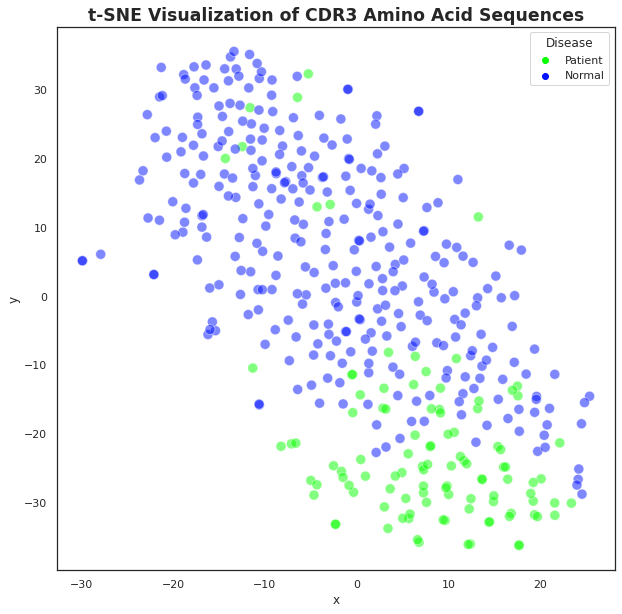

In [ ]:
# Create visualization using Matplotlib and Seaborn
sns.set(rc={ 'figure.figsize':(10.0, 10.0) }, style='white')
sns.scatterplot(x='x', y='y', hue='Disease', palette='hsv', s=100, alpha=0.5, data=final_df_cdr)
plt.title('t-SNE Visualization of CDR3 Amino Acid Sequences', fontweight='bold', fontsize='x-large')
plt.show()

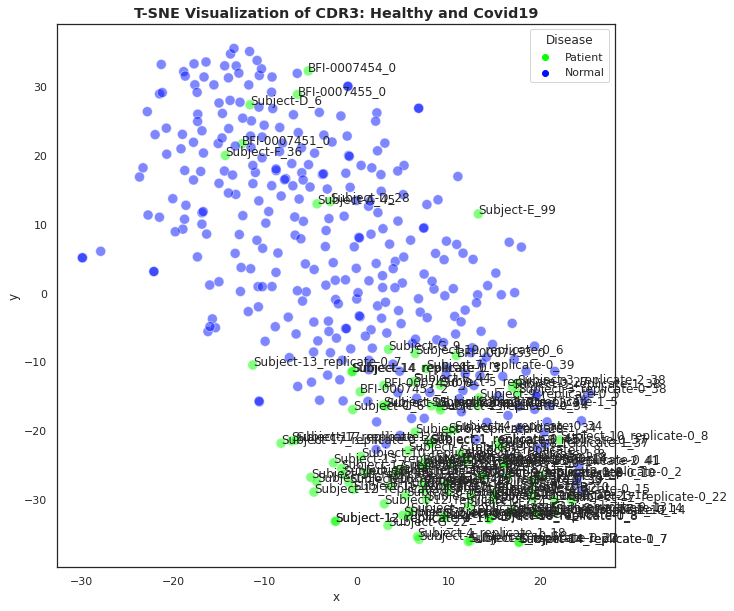

In [ ]:
# Create visualization using Matplotlib and Seaborn
sns.set(rc={ 'figure.figsize':(10.0, 10.0) }, style='white')
sns.scatterplot(x='x', y='y', hue='Disease', palette='hsv', s=100, alpha=0.5, data=final_df_cdr)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if not pd.isnull(point['val']):
            ax.text(point['x'], point['y'], str(point['val']))

label_point(final_df_cdr.x, final_df_cdr.y, final_df_cdr.Subjects, plt.gca())  

plt.title('T-SNE Visualization of CDR3: Healthy and Covid19', fontweight='bold', fontsize='large')
plt.show()

### Create ML Classification Model - XGBoost

In [ ]:
# Import necessary libraries and packages
from sklearn import svm                              
from sklearn import metrics   
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBClassifier                   

In [ ]:
# Drop unnecessary columns (xy coordinates used in t-SNE visualiztion)
final_df_cdr_drop = final_df_cdr.drop(['x', 'y', 'Subjects'], axis=1)
final_df_cdr_drop

In [ ]:
from xgboost import XGBClassifier

# 5-fold Cross Validation procedures
df = final_df_cdr_drop[:]

# Separate labels (y) and data (x) 
labels = df.iloc[:,0].values
data = df.iloc[:,1:].values

skf = StratifiedKFold(n_splits=5, shuffle=True)

# Accuracy scores to calculate the average of 5 separate scores
acc_scores = []

for i, (train, test) in enumerate(skf.split(data, labels)):

    y_train = pd.DataFrame(labels[train,][:,np.newaxis])
    X_train = pd.DataFrame(data[train,])

    y_test = pd.DataFrame(labels[test,][:,np.newaxis])
    X_test = pd.DataFrame(data[test,])

    # Use XGBoost Classifier
    model2 = XGBClassifier(n_estimators=1000)

    # Train the algorithm with training input and output data
    model2.fit(X_train, y_train.values.ravel()) 

    # Pass the testing data to the trained model for prediction
    prediction = model2.predict(X_test) 

    # Display the accuracy score
    acc_score = metrics.accuracy_score(y_test, prediction)
    print(f'The accuracy of the XGBoost Model Trial {i+1}:', acc_score)

    acc_scores.append(acc_score)

print("*"*70)
print("Average accuracy rate:",sum(acc_scores)/5)